# Imports and constants

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import cv2 as cv
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from math import ceil

In [2]:
# directory with the coco images
dir_ = "D:/Datasets/COCO/Images/train2014/"

# directory with the annotations bounding boxes
data_annotation_path = "D:/Datasets/COCO/Annotations/annotations/instances_train2014.json"

In [3]:
# initialize COCO api for instance annotations
coco = COCO(data_annotation_path)

loading annotations into memory...
Done (t=9.44s)
creating index...
index created!


In [4]:
# number of classes 
global num_classes_coco
num_classes_coco = len(coco.cats.keys())

In [5]:
# temporary grid size
grid_size = (25,37)
images_dim = (600,400)

# Utils

In [6]:
def Get_images_batch_from_COCO(batch_size, coco, grid_size, images_dim):
    ''' This function produces the batches for the training'''
    
    # get all images containing given categories, select one at random
    catIds = coco.getCatIds(catNms=coco.cats)

    # get all images through their IDs
    imgIds = coco.getImgIds(catIds=catIds )
    
    while True:
        # iamges batch
        batch = []
        batch_anns  = []
        detection_grid = []
        
        for i in range(batch_size):

            # random select an image and its annotations
            img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
            annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

            ### load the image and the annotations ###
            image = cv.imread(os.path.join(dir_,img["file_name"]))
            
            # cvtColor changes the color conversion
            rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image_H = rgb_image.shape[0]
            image_W = rgb_image.shape[1]
            
            # resize the image
            rgb_image = cv.resize(rgb_image, images_dim)
            
            
            #load annotations
            anns = coco.loadAnns(annIds)

            # append the image to the batch and annotations to batch_anns
            batch.append(rgb_image)
            temp_annotations = Parse_annotations(anns,image_H,image_W)
            batch_anns.append(temp_annotations)       
            
            ## build detection grid
            detection_grid.append(Build_detection_grid(temp_annotations,grid_size,num_classes_coco))
            
        yield np.array(batch, dtype='object').astype('float32'), np.array(detection_grid, dtype='object').astype('float32')
        
def Parse_annotations(annotations,image_H,image_W):
    '''
    This function returns a list of lists. Each element of the main list contains the parameters of a of a bounding box:
    
    - x: center coordinate x 
    - y: center coordinate y 
    - w: width of the bounding box
    - h: height of the bounding box
    - class: class of the object inside the bounding box
    
    '''
    data = []
    for annotation in annotations:
        bbox = Rescale_BB_coordinates(annotation['bbox'],image_H,image_W)
        category_id = annotation['category_id']
        bbox.append(category_id)
        data.append(bbox)
    return data

def Rescale_BB_coordinates(data,image_H,image_W):
    '''rescale BB coordinates according to iamge dimensions:
    - output: center_x, center_y, width, height 
    - input: upper_left_x, upper_left_y, width, height'''
    n_data = []
    n_data.append((data[0]+data[2]/2)/image_W) # x
    n_data.append((data[1]+data[3]/2)/image_H) # y
    n_data.append((data[2])/image_W) # w 
    n_data.append((data[3])/image_H) # h
    return n_data

def Norm2Orig(x0,y0,w,h,image_size):
    '''Changes the coordinates from the scale [0,1] to the original annotation size'''
    image_H = image_size[0] 
    image_W = image_size[1]
    center_x = int(x0*image_W)
    center_y = int(y0*image_H)
    W = int(w*image_W)
    H = int(h*image_H)
    return center_x,center_y,W,H
 
def Build_detection_grid(annotations,grid_size,num_classes,priors=[(1.0,1.0)]):
    '''This function builds the detection grid associated with each image:
    - input: image_size = (image_Width, image_Height)
    - output: (grid_size[0],grid_size[1],B*(5+C)) where B is the number of priors and C the number of classes 
    '''
    
    # initialize the grid
    grid_volume = (grid_size[0],grid_size[1],len(priors)*(5+num_classes))
    grid = np.zeros(grid_volume)
        
    for annotation in annotations:
        
        # unpack annotations
        x,y,w,h,label = annotation
        
        # find the Grid Cell (GC) responsible for the detection        
        resp_GC_x = int(x*grid_size[0])
        resp_GC_y = int(y*grid_size[1])
            
        for prior in priors:
        
            # create labels vector
            labels = np.zeros(num_classes_coco)
            # pay attention that the correct label is equal to the position where labels==1 +1
            labels[label-1]=1

            # fill responsible Grid Cell (1:boxiness)
            grid[resp_GC_x,resp_GC_y,:5] = x,y,w,h,1
            grid[resp_GC_x,resp_GC_y,5:] = labels
    
    return grid

In [45]:
def Draw_BB(orig_image, image_datas, coco, fontscale=.7, bb_thickness=2):
    
    '''Draw bounding boxes on an image
    
    - output: copy of the original image with overlapped BB
    - input: image, annotations for the image, coco '''
    
    # copy the original image to not modify the original
    image = np.copy(orig_image).astype(int)
    image_H = image.shape[0]
    image_W = image.shape[1]
    
    for image_data in image_datas:
        
        try:
            # unpack image data
            x0, y0, w, h, label_ = image_data
        except: 
            # unpack image data with boxiness
            x0, y0, w, h, boxiness,  label_ = image_data
        
        # rescale the center and dimensions of the BB
        cetnter_x,center_y,W,H = Norm2Orig(x0,y0,w,h,(image_H,image_W))
        
        # build start and stop point for bb
        start_point = (cetnter_x-int(W/2), center_y+int(H/2))
        stop_point = (cetnter_x+int(W/2), center_y-int(H/2))

        # draw the rectangle
        image = cv.rectangle(image, start_point, stop_point, color=(0,0,255), thickness=5)
        
        # draw bboxes centers
        cv.circle(image,(cetnter_x,center_y),radius=0,color=(0,0,255),thickness=10)

        # write BB class
        try:
            label = coco.cats[int(label_)]['name']
            text_origin = start_point
            font = cv.FONT_HERSHEY_SIMPLEX 
            fontScale=fontscale
            color=(0,255,0)
            thickness=bb_thickness
            image = cv.putText(image, label, text_origin, font,  fontScale, color, thickness, cv.LINE_AA)
        except Exception as e:
            print(e)
    
    return image

def Draw_grid(orig_image,grid_size):
    '''This function draws the detection grid on a copy of the original image
    
    -inputs:original image and grid sizes
    -output:copy of the original image with the grid on top
    
    '''
    
    # copy the original image to not modify the original
    image = np.copy(orig_image)
    image_H = image.shape[0]
    image_W = image.shape[1]
    
    # draw vertical lines
    for i in range(grid_size[0]):
        start = (int(image_W*i/grid_size[0]),0)
        stop = (int(image_W*i/grid_size[0]),image_H)
        cv.line(image,start,stop,(255,0,0),2,2)
        
    # draw orizontal lines
    for j in range(grid_size[1]):
        start = (0,int(image_H*j/grid_size[0]))
        stop = (image_W,int(image_H*j/grid_size[0]))
        cv.line(image,start,stop,(255,0,0),2,2)
        
    return image

def DetectionGrid2ImageDetection(detection_grid):
    
    '''This function returns an array of size (batch_size, ). Each of the batches contains a list of lists containing the bboxes
       coordinates and parameters. The output should be correctly interpreted by the DrawBBo function.
    '''
    
    def Unpack_grid(grid,detections_coord_x,detections_coord_y,i):

        # positions of detections on the grid 
        posX,posY = detections_coord_x[i],detections_coord_y[i]

        # current box parameters
        x = grid[posX,posY,0]
        y = grid[posX,posY,1]
        w = grid[posX,posY,2]
        h = grid[posX,posY,3]
        boxiness = grid[posX,posY,4]
        label = np.argmax(grid[posX,posY,5:]) + 1

        return x,y,w,h,boxiness,label
        
    bboxes = []

    for grid in detection_grid:

        #current bounding box
        current_image_bboxes = []

        # x layer
        first_layer = grid[:,:,0]
        detections_coord_x, detections_coord_y = np.where(first_layer>0)

        for i in range(len(detections_coord_x)):

            x,y,w,h,boxiness,label = Unpack_grid(grid,detections_coord_x,detections_coord_y,i)

            current_image_bboxes.append([x,y,w,h,boxiness,label])

        bboxes.append(np.array(current_image_bboxes))

    return np.array(bboxes, dtype='object')

# Run

In [8]:
# build the generator
gen_ = Get_images_batch_from_COCO(2, coco, grid_size, images_dim)

In [9]:
# get a batch
batch, detection_grid = gen_.__next__()

In [10]:
bboxes = DetectionGrid2ImageDetection(detection_grid)

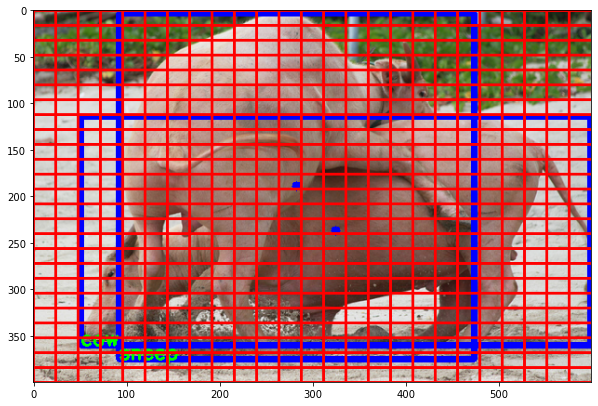

In [11]:
# Draw BBox
test_image =decoded = Draw_BB(batch[0],bboxes[0],coco)
test_image = Draw_grid(test_image, grid_size)
plt.figure(figsize=(10,10))
plt.imshow(test_image)

In [12]:
# # check the position of bboxes centers with respect to the grid
# f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(13,13))
# ax1.matshow(detection_grid[0,:,:,0], cmap='gray')
# ax2.matshow(np.diag(np.ones(grid_size[0]))+.5*detection_grid[0,:,:,0], cmap='gray')

# Loss functions

These are loss functions are implemented in: https://arxiv.org/abs/1506.02640

## Localization loss

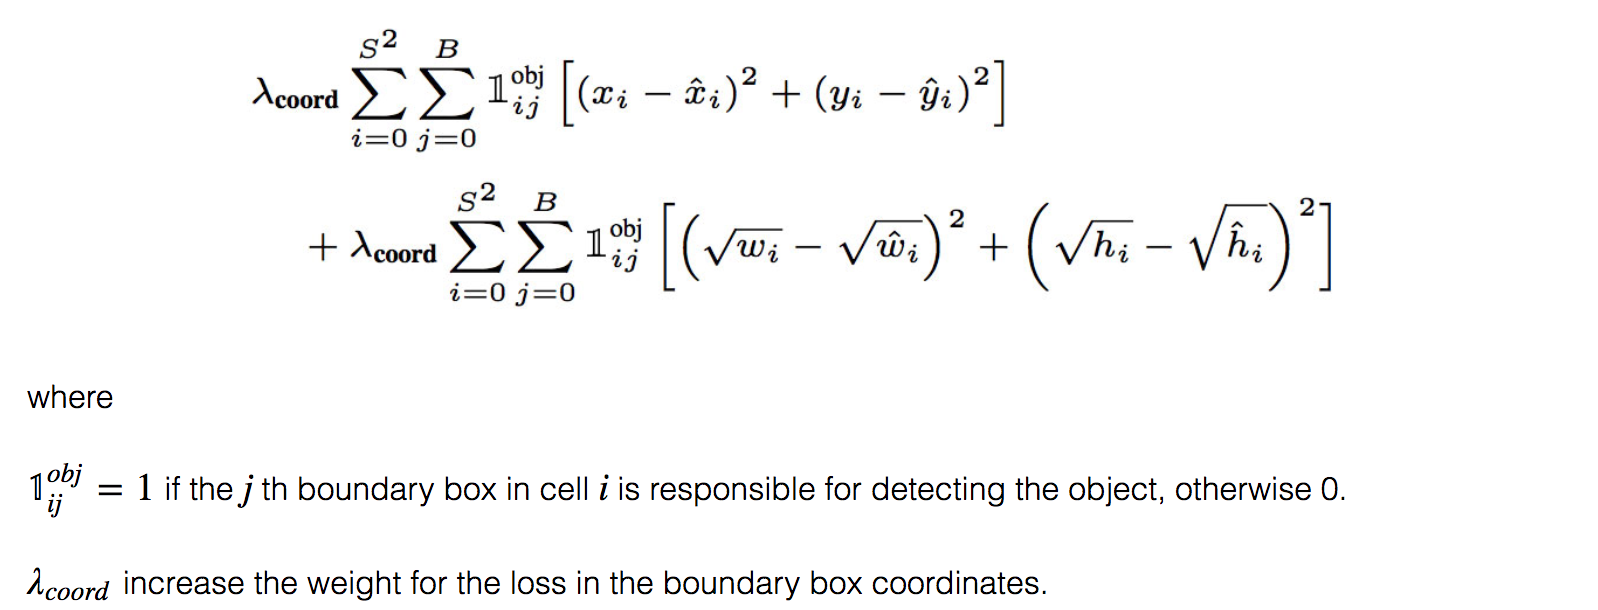

In [13]:
def Localization_Loss(detection_grid_pred, detection_grid_true):
    
    # weight
    lambda_obj = 5
    
    # compute the square difference elementwise
    subtraction_squared = tf.math.squared_difference(detection_grid_true[:,:,:,:5],detection_grid_pred[:,:,:,:5])
    
    # summs over the tensor dimensions returning a single value
    loss = tf.reduce_sum(subtraction_squared)
        
    return lambda_obj*loss

## Classification and Confidence losses

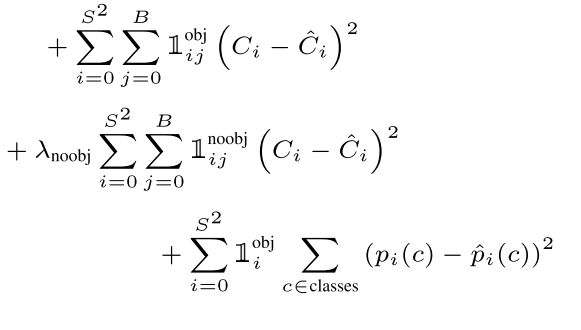

In [14]:
def C_and_C_Loss(detection_grid_pred, detection_grid_true):
    
    # weight
    lambda_obj = .5
    
    # compute the square difference elementwise
    subtraction_squared = tf.math.squared_difference(detection_grid_true[:,:,:,5:],detection_grid_pred[:,:,:,5:])
    
    # summs over the tensor dimensions returning a single value
    loss = tf.reduce_sum(subtraction_squared)
        
    return lambda_obj*loss

## Total loss

In [15]:
def Total_loss(detection_grid_pred, detection_grid_true):    
    return C_and_C_Loss(detection_grid_pred, detection_grid_true) + Localization_Loss(detection_grid_pred, detection_grid_true)

# Training

## Define the model

In [16]:
# temporary model
from Deep_Model import *

In [17]:
help(Build_model)

Help on function Build_model in module Deep_Model:

Build_model(initializer_, input_image_size, BB_per_cell, Classes, batch_, model_name)



In [18]:
# size of the input images
input_image_size = (400,600,3)

# bounding boxes per cell
BB_per_cell = 1

# number of classes in the dataset
Classes = num_classes_coco

# Batch size
batch_ = 8

# Weight matrix initialization whenever using relu
initializer_ = tf.keras.initializers.he_normal()

In [19]:
model = Build_model(initializer_, input_image_size, BB_per_cell, Classes, batch_, "My_SSD")

In [20]:
model.summary()

Model: "My_SSD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(8, 400, 600, 3)]        0         
_________________________________________________________________
conv_1 (Conv2D)              (8, 400, 600, 256)        7168      
_________________________________________________________________
pool_1 (MaxPooling2D)        (8, 200, 300, 256)        0         
_________________________________________________________________
batch_normalization (BatchNo (8, 200, 300, 256)        1024      
_________________________________________________________________
conv_2 (Conv2D)              (8, 200, 300, 128)        295040    
_________________________________________________________________
pool_2 (MaxPooling2D)        (8, 100, 150, 128)        0         
_________________________________________________________________
batch_normalization_1 (Batch (8, 100, 150, 128)        512  

## Callbacks

In [21]:
# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1, mode='min',restore_best_weights=True)

In [22]:
from tensorboard_setup_class import *

# Tensorboard
tensorboard= tensor_board_setup()
tensorboard_callback = tensorboard.setup()

In [23]:
CallBacks = [early_stopping_callback, tensorboard_callback]

## Train the model

In [24]:
#generator
training_gen_ = Get_images_batch_from_COCO(batch_, coco, grid_size, images_dim)

# compile the model
model.compile( loss = Total_loss, optimizer='Adam')

In [25]:
# batch and output dimensions
a,b = training_gen_.__next__()
print('images batch {}'.format(a.shape))
print('detection grid {}'.format(b.shape))

images batch (8, 400, 600, 3)
detection grid (8, 25, 37, 95)


In [26]:
# train the model with generator
history = model.fit(training_gen_, steps_per_epoch=30, epochs=50, callbacks=CallBacks)

  ...
    to  
  ['...']
Train for 30 steps
Epoch 1/50
30/30 [==============================] - 22s 732ms/step - loss: 180052.0233
Epoch 2/50
30/30 [==============================] - 23s 758ms/step - loss: 17981.1149
Epoch 3/50
30/30 [==============================] - 22s 729ms/step - loss: 5722.7861
Epoch 4/50
30/30 [==============================] - 23s 771ms/step - loss: 2617.6772
Epoch 5/50
30/30 [==============================] - 23s 751ms/step - loss: 1382.5249
Epoch 6/50
30/30 [==============================] - 21s 710ms/step - loss: 957.2928
Epoch 7/50
30/30 [==============================] - 22s 735ms/step - loss: 808.1737
Epoch 8/50
30/30 [==============================] - 24s 785ms/step - loss: 723.1150
Epoch 9/50
30/30 [==============================] - 20s 676ms/step - loss: 690.1196
Epoch 10/50
30/30 [==============================] - 22s 722ms/step - loss: 585.5177
Epoch 11/50
30/30 [==============================] - 21s 700ms/step - loss: 688.6979


# Test the model

In [27]:
a,b = training_gen_.__next__()

In [28]:
tmp = model(a)

In [29]:
bboxes = DetectionGrid2ImageDetection(tmp.numpy())

In [30]:
# ground truth
gt = DetectionGrid2ImageDetection(b)

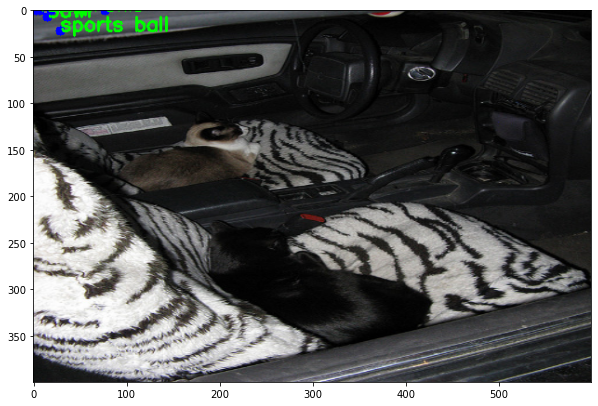

In [48]:
# Draw BBox
test_image =decoded = Draw_BB(a[0,...],bboxes[0],coco)
plt.figure(figsize=(10,10))
plt.imshow(test_image)

In [32]:
bboxes[0]

array([[1.28361642e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.50000000e+01],
       [2.63258778e-02, 1.95856988e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.10000000e+01],
       [3.25336717e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.06034108e-01, 6.20000000e+01],
       [5.77187166e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.00000000e+01],
       [4.91184257e-02, 5.55491149e-02, 0.00000000e+00, 0.00000000e+00,
        2.19944000e-01, 3.70000000e+01],
       [3.55955213e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.19792947e-02, 1.70000000e+01],
       [1.27766095e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.80000000e+01]])

In [39]:
coco.cats[int(29)]['name']

KeyError: 29

In [44]:
len(coco.cats.keys())

80